In [29]:
using Distributions
using LinearAlgebra
using Plots

In [30]:
include("../testfns.jl")
include("../rollout.jl")
include("../utils.jl")

generate_initial_guesses (generic function with 1 method)

In [101]:
MC_SAMPLES = 1000
NUMBER_OF_STARTS = 16
NUMBER_OF_TRIALS = 1
HORIZON = 1
BATCH_SIZE = 8

# Gaussian process hyperparameters
θ, σn2 = [.25], 1e-6
ψ = kernel_matern52(θ)
# testfn = TestLinearCosine1D(1., 10.2)
testfn = TestConstant(lbs=[0.], ubs=[1.])
lbs, ubs = testfn.bounds[:, 1], testfn.bounds[:, 2]

# Generate low discrepancy sequence
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON + 1)
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

# Allocate initial guesses for optimizer
initial_guesses = generate_initial_guesses(NUMBER_OF_STARTS, lbs, ubs)

# Allocate all initial samples
initial_samples = randsample(NUMBER_OF_TRIALS, testfn.dim, lbs, ubs)

# Initialize the trajectory parameters
tp = TrajectoryParameters(
    initial_samples[:, 1], # Will be overriden later
    HORIZON,
    MC_SAMPLES,
    lds_rns,
    # rns,
    lbs,
    ubs,
)

# Initialize batch of points to evaluate the rollout acquisition function
batch = generate_batch(BATCH_SIZE, lbs=tp.lbs, ubs=tp.ubs)

# Initialize shared memory for solving base policy in parallel
candidate_locations = SharedMatrix{Float64}(testfn.dim, NUMBER_OF_STARTS)
candidate_values = SharedArray{Float64}(NUMBER_OF_STARTS)

trial = first(rand(1:NUMBER_OF_TRIALS, 1))
# Xinit = initial_samples[:, trial:trial]
# Xinit = [-.95;; -.9;; -.85;; .85;; .9;; .95;;]
Xinit = [.15;; .85;;]
yinit = testfn.f.(eachcol(Xinit))
sur = fit_surrogate(ψ, Xinit, yinit; σn2=σn2);

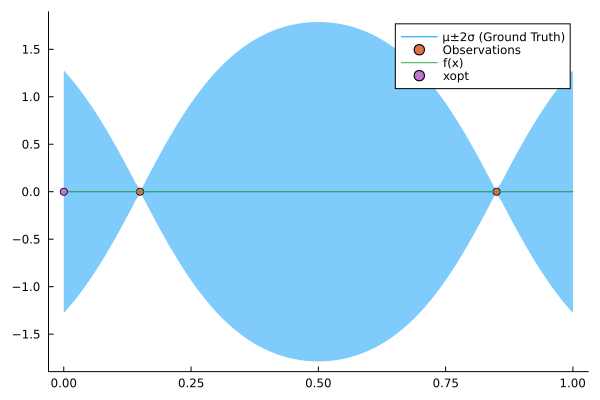

In [102]:
p = plot1D(sur; xmin=first(lbs), xmax=first(ubs))
xx = range(testfn.bounds[1,1], testfn.bounds[1,2], length=250)
plot!(xx, (x) -> testfn([x]), label="f(x)")
scatter!(p, [xy[1] for xy in testfn.xopt], [testfn(xy) for xy in testfn.xopt], label="xopt")

In [103]:
domain = first(lbs):.01:first(ubs)
dense_evals = zeros(length(domain), 4)

for (i, x0) in enumerate(domain)
    print("|")
    tp.x0[:] = [x0]

    
    outcome = simulate_trajectory(sur, tp, initial_guesses, variance_reduction=false,
        candidate_locations=candidate_locations, candidate_values=candidate_values
    )
    dense_evals[i, :] .= [outcome[1], first(outcome[2]), outcome[3], first(outcome[4])]
end

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

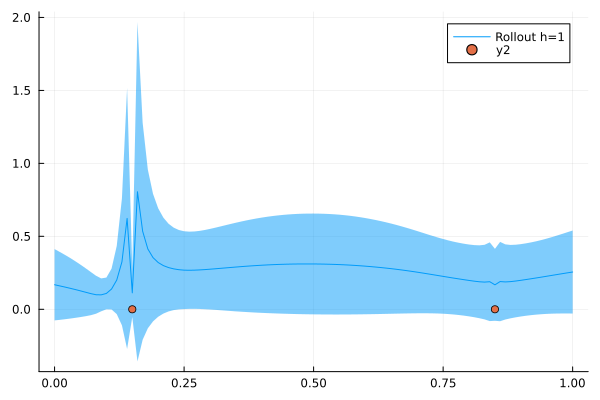

In [104]:
plot(
    domain,
    dense_evals[:, 1],
    ribbons=dense_evals[:, 3],
    label="Rollout h=$HORIZON"
)
scatter!(sur.X', zeros(length(sur.X')))

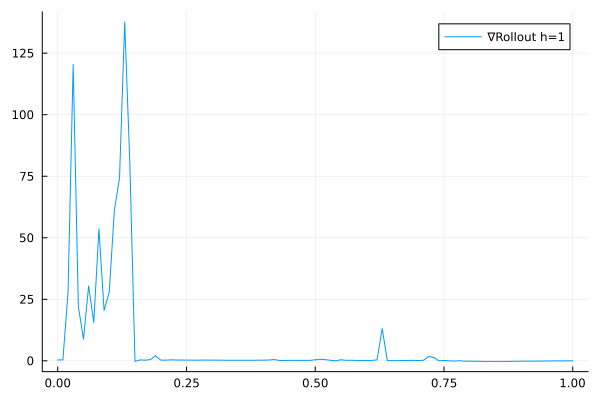

In [105]:
plot(
    domain,
    dense_evals[:, 2],
    # ribbons=dense_evals[:, 4],
    label="∇Rollout h=$HORIZON"
)

In [64]:
# Optim.Options(x_tol=1e-3, f_tol=1e-3)
function rollout_constructor(
    s::RBFsurrogate,
    tp::TrajectoryParameters,
    xstarts::Matrix{Float64};
    variance_reduction::Bool=false,
    candidate_locations::SharedMatrix{Float64},
    candidate_values::SharedArray{Float64})
    function rollout(x)
        tp.x0[:] = x
        μx, ∇μx, _, _ = simulate_trajectory(sur, tp, xstarts,
            variance_reduction=variance_reduction,
            candidate_locations=candidate_locations,
            candidate_values=candidate_values
        )

        return -μx
    end

    function grollout!(g, x)
        tp.x0[:] = x
        μx, ∇μx, _, _ = simulate_trajectory(sur, tp, xstarts,
            variance_reduction=variance_reduction,
            candidate_locations=candidate_locations,
            candidate_values=candidate_values
        )
        g[:] = -∇μx
    end

    return (rollout, grollout!)
end

rollout, grollout! = rollout_constructor(
    sur, tp, initial_guesses,
    candidate_locations=candidate_locations,
    candidate_values=candidate_values,
    variance_reduction=true
)

(rollout, grollout!)

In [65]:
results = []
xstarts = range(first(lbs) + .01, first(ubs) - .01, length=16)

for x in xstarts
    println("Solving Acquisition Iteratively Starting at $(x)")
    # push!(
    #     results,
    #     optimize(
    #         rollout, grollout!, [x], LBFGS(), Optim.Options(x_tol=1e-6, f_tol=1e-6)
    #     )
    # )
    push!(
        results,
        optimize(
            rollout, grollout!, testfn.bounds[:, 1], testfn.bounds[:, 2], [x], IPNewton(),
            Optim.Options(x_tol=1e-6, f_tol=1e-6)
        )
    )
end

# inner_optimizer = GradientDescent()
# results = optimize(
#     rollout, grollout!, testfn.bounds[:, 1], testfn.bounds[:, 2], [-.3], IPNewton(),
#     Optim.Options(x_tol=1e-3, f_tol=1e-3)
# )

Solving Acquisition Iteratively Starting at -0.99
Solving Acquisition Iteratively Starting at -0.858
Solving Acquisition Iteratively Starting at -0.726
Solving Acquisition Iteratively Starting at -0.594
Solving Acquisition Iteratively Starting at -0.462
Solving Acquisition Iteratively Starting at -0.33


LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
      [1] [0m[1mArray[22m
    [90m    @[39m [90m./[39m[90m[4mboot.jl:477[24m[39m[90m [inlined][39m
      [2] [0m[1mArray[22m
    [90m    @[39m [90m./[39m[90m[4mboot.jl:486[24m[39m[90m [inlined][39m
      [3] [0m[1msimilar[22m
    [90m    @[39m [90m./[39m[90m[4marray.jl:420[24m[39m[90m [inlined][39m
      [4] [0m[1msimilar[22m
    [90m    @[39m [90m./[39m[90m[4mabstractarray.jl:831[24m[39m[90m [inlined][39m
      [5] [0m[1m_unsafe_getindex[22m
    [90m    @[39m [90m./[39m[90m[4mmultidimensional.jl:901[24m[39m[90m [inlined][39m
      [6] [0m[1m_getindex[22m
    [90m    @[39m [90m./[39m[90m[4mmultidimensional.jl:889[24m[39m[90m [inlined][39m
      [7] [0m[1mgetindex[22m
    [90m    @[39m [90m./[39m[90m[4mabstractarray.jl:1291[24m[39m[90m [inlined][39m
      [8] [0m[1mmacro expansion[22m
    [90m    @[39m [90m~/Documents/academia/cornell-university/research/projects/kernel-numerics-refactor-revamp/[39m[90m[4mrbf_optim.jl:70[24m[39m[90m [inlined][39m
      [9] [0m[1m(::var"#1422#1423"{SharedMatrix{Float64}, SharedVector{Float64}, FantasyRBFsurrogate, Vector{Float64}, Vector{Float64}, Matrix{Float64}})[22m[0m[1m([22m[90mR[39m::[0mUnitRange[90m{Int64}[39m, [90mlo[39m::[0mInt64, [90mhi[39m::[0mInt64[0m[1m)[22m
    [90m    @[39m [35mMain[39m [90m~/.julia/juliaup/julia-1.10.2+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/Distributed/src/[39m[90m[4mmacros.jl:303[24m[39m
     [10] [0m[1m(::Distributed.var"#178#180"{UnitRange{Int64}, var"#1422#1423"{SharedMatrix{Float64}, SharedVector{Float64}, FantasyRBFsurrogate, Vector{Float64}, Vector{Float64}, Matrix{Float64}}, UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [36mDistributed[39m [90m~/.julia/juliaup/julia-1.10.2+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/Distributed/src/[39m[90m[4mmacros.jl:83[24m[39m
     [11] [0m[1m#invokelatest#2[22m
    [90m    @[39m [90m./[39m[90m[4messentials.jl:892[24m[39m[90m [inlined][39m
     [12] [0m[1minvokelatest[22m
    [90m    @[39m [90m./[39m[90m[4messentials.jl:889[24m[39m[90m [inlined][39m
     [13] [0m[1m#153[22m
    [90m    @[39m [90m~/.julia/juliaup/julia-1.10.2+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/Distributed/src/[39m[90m[4mremotecall.jl:425[24m[39m[90m [inlined][39m
     [14] [0m[1mrun_work_thunk[22m[0m[1m([22m[90mthunk[39m::[0mDistributed.var"#153#154"[90m{Distributed.var"#178#180"{UnitRange{Int64}, var"#1422#1423"{SharedMatrix{Float64}, SharedVector{Float64}, FantasyRBFsurrogate, Vector{Float64}, Vector{Float64}, Matrix{Float64}}, UnitRange{Int64}}, Tuple{}, @Kwargs{}}[39m, [90mprint_error[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [36mDistributed[39m [90m~/.julia/juliaup/julia-1.10.2+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/Distributed/src/[39m[90m[4mprocess_messages.jl:70[24m[39m
     [15] [0m[1mrun_work_thunk[22m[0m[1m([22m[90mrv[39m::[0mDistributed.RemoteValue, [90mthunk[39m::[0mFunction[0m[1m)[22m
    [90m    @[39m [36mDistributed[39m [90m~/.julia/juliaup/julia-1.10.2+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/Distributed/src/[39m[90m[4mprocess_messages.jl:79[24m[39m
     [16] [0m[1m(::Distributed.var"#100#102"{Distributed.RemoteValue, Distributed.var"#153#154"{Distributed.var"#178#180"{UnitRange{Int64}, var"#1422#1423"{SharedMatrix{Float64}, SharedVector{Float64}, FantasyRBFsurrogate, Vector{Float64}, Vector{Float64}, Matrix{Float64}}, UnitRange{Int64}}, Tuple{}, @Kwargs{}}})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [36mDistributed[39m [90m~/.julia/juliaup/julia-1.10.2+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/Distributed/src/[39m[90m[4mprocess_messages.jl:88[24m[39m
    Stacktrace:
     [1] [0m[1msync_end[22m[0m[1m([22m[90mc[39m::[0mChannel[90m{Any}[39m[0m[1m)[22m
    [90m   @[39m [90mBase[39m [90m./[39m[90m[4mtask.jl:448[24m[39m
     [2] [0m[1mmacro expansion[22m
    [90m   @[39m [90m./[39m[90m[4mtask.jl:480[24m[39m[90m [inlined][39m
     [3] [0m[1m(::Distributed.var"#177#179"{var"#1422#1423"{SharedMatrix{Float64}, SharedVector{Float64}, FantasyRBFsurrogate, Vector{Float64}, Vector{Float64}, Matrix{Float64}}, UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [36mDistributed[39m [90m~/.julia/juliaup/julia-1.10.2+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/Distributed/src/[39m[90m[4mmacros.jl:278[24m[39m

Unhandled Task ERROR: InterruptException:
Stacktrace:
  [1] Array
    @ ./boot.jl:477 [inlined]
  [2] Array
    @ ./boot.jl:486 [inlined]
  [3] similar
    @ ./array.jl:420 [inlined]
  [4] similar
    @ ./abstractarray.jl:831 [inlined]
  [5] _unsafe_getindex
    @ ./multidimensional.jl:901 [inlined]
  [6] _getindex
    @ ./multidimensional.jl:889 [inlined]
  [7] getindex
    @ ./abstractarray.jl:1291 [inlined]
  [8] macro expansion
    @ ~/Documents/academia/cornell-university/research/projects/kernel-numerics-refactor-revamp/rbf_optim.jl:70 [inlined]
  [9] (::var"#1422#1423"{SharedMatrix{Float64}, SharedVector{Float64}, FantasyRBFsurrogate, Vector{Float64}, Vector{Float64}, Matrix{Float64}})(R::UnitRange{Int64}, lo::Int64, hi::Int64)
    @ Main ~/.julia/juliaup/julia-1.10.2+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/Distributed/src/macros.jl:303
 [10] (::Distributed.var"#178#180"{UnitRange{Int64}, var"#1422#1423"{SharedMatrix{Float64}, SharedVector{Float64}, FantasyRBFsurrogate

In [66]:
xx = first.(Optim.minimizer.(results))
yy = -Optim.minimum.(results)

5-element Vector{Float64}:
 7.077828684219498e-95
 0.43093694514915165
 0.20717054798892015
 0.2673637313941439
 0.18970605368728666

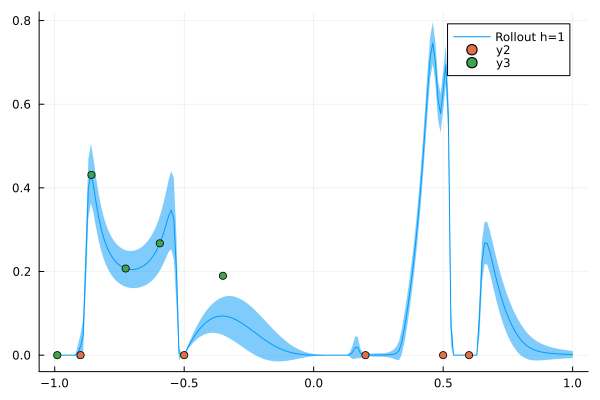

In [67]:
plot(
    domain,
    dense_evals[:, 1],
    ribbons=dense_evals[:, 3],
    label="Rollout h=$HORIZON"
)
scatter!(sur.X', zeros(length(sur.X')))
scatter!(xx, yy)